<a href="https://colab.research.google.com/github/acse-moj20/msc-irp/blob/dev/PredGAN/PredGAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dev Code (PredGAN) For Fluid Problem. Version: 1**

Specs:
- POD coefficients: 292
- GAN Architecture 
  - generator: Modified. Additional conv2dT layer and filter size.
  - disciriminator: Modified. 2 additional conv2d layers. 
- Learning_rate: 1e-4
- ntimes: 21; steps: 1
- number generated: 5
- Batch_size: 256
- Epochs: 50,000

Setup and package import

In [1]:
%matplotlib inline
import sys
import os
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import joblib
import time


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Processing Power and Available Memory

GPU Specs

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('GPU info not found.')
else:
  print(gpu_info)

print('Num of available GPUs: ', len(tf.config.list_physical_devices('GPU')))

Wed Jul  7 11:54:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Memory Allocation

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM



#Utility Functions

In [74]:
## UTILITY FUNCTIONS FOR VISUALIZATION AND ERROR MEASUREMENT

def calculate_error(data, data_recovered):
  abs_error = abs(data - data_recovered)
  perc_error = abs_error*100/abs(data)

  return np.max(abs_error), np.mean(abs_error)

def plot_vortex(data, times, cols, rows=1):
  fig, ax = plt.subplots(rows, cols, figsize=[20, 5*cols], constrained_layout=True)
  
  for i, step in enumerate(times):
    im = ax.flatten()[i].imshow(data[step], cmap='RdBu')
    cbar = plt.colorbar(im, ax=ax.flatten()[i], shrink=0.5, pad=0.05, panchor=(0.0, 0.0))
    #ax[i].set_xticklabels([]), ax[i].set_yticklabels([])
    #ax[i].set_xticks([]), ax[i].set_yticks([])
    
    ax.flatten()[i].set_title('t = {}'.format(step), y=1.05, 
                          fontsize=16, fontweight="bold")
  plt.show()


def concat_timesteps(X_train, ntimes, step, window_start, window_end):
    X_train_concat = []
    for start, end in zip(window_start, window_end):
      for i in range(start, end+1): 
        X_train_concat.append(X_train[i:i+ntimes*step:step])
        #print('{}-{}'.format(i, i+ntimes*step) , end=', ')
      #print('\n')
    return np.array(X_train_concat)

def invert_data(X_data):
  X_scale_inverted = scaler.inverse_transform(X_data)
  X_pca_inverted = pca.inverse_transform(X_scale_inverted)
  return X_pca_inverted

def transform_data(X_data):
  X_pca = pca.fit_transform(X_data)
  X_pca_scaled = scaler.fit_transform(X_pca)
  return X_pca_scaled

# Model Reduction

##**Data Details**

What we know so far:


*   Dataset represents the parameter values of u, v and p for 100 separate examples of the high fidelity solution.
*   Each example is computed over 50 timesteps and a on a 256-by-256 grid.

*   Vorticity over the vector field is obatined by computing the curl of u (x-component velocity vector) and v (y-component velocity vector)






##**Raw data transformation**

**Get Data from Drive and transform**

To be run only once

In [ ]:
# data_dir = 'drive/MyDrive/MSC_IRP/data/vortex_100.npy'

# # Load x and y velocity components.
# data_file = np.load(data_dir)

# print('Size of dataset:         ', data_file.shape)
# print('Number of data samples:  ', len(data_file))
# print('Size of each sample:     ', data_file[0].shape)
# print('Number of time steps:    ', len(data_file[0]))

Size of dataset:          (100, 50, 256, 256, 3)
Number of data samples:   100
Size of each sample:      (50, 256, 256, 3)
Number of time steps:     50


In [ ]:

# # Data transformation - computing vorticity from vector field.
# # vorticity is the curl of the velocity vector field (raw dataset).

# def curl(u,v):
#   """ 
#   Function to calculate the curl of a 2-dimensional vector field.
#   Parameters:
#   -----------
#     u : 2d array of size n*m
#       vector component in the x direction.

#     v : 2d array of size n*m
#       vector component in the y direction
#   Output:
#   -------
#     curl : 2d array of size n*m
#       curl of vector field [i.e. (dv/dx)i - (du/dy)j]
#   """
#   curl = np.gradient(v)[0] - np.gradient(u)[1]
#   return curl


**Save Transformed Data to Drive**

To be run only once

In [ ]:
# Compute and save vorticity for easier data loading

# vorticity = np.zeros((100, 50, 256, 256))
# for i in range(len(data_file)):
#  for j in range(len(data_file[0])):
#    vorticity[i][j] = curl(data_file[i][j][:, :, 0], data_file[i][j][:, :, 1])
# save_dir = 'drive/MyDrive/MSC_IRP/data/calc_vortex_100.npy'
# np.save(save_dir, vorticity)

##**Dataset visualization**

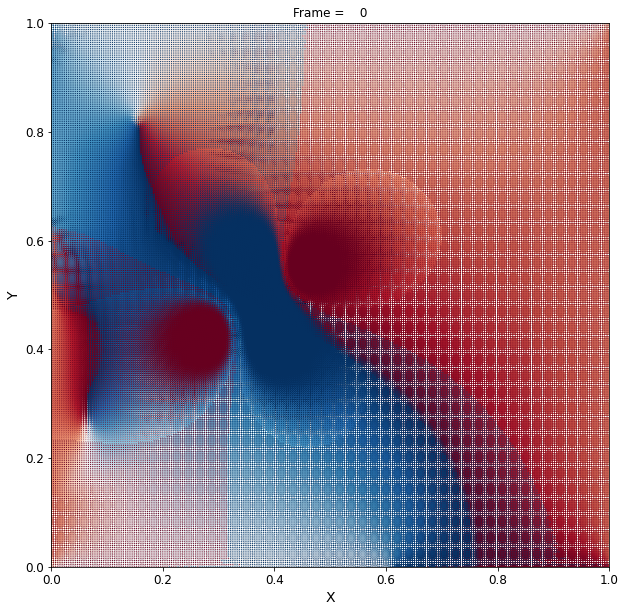

In [ ]:
import seaborn as sns
from matplotlib import animation

# # create a figure and axes
# fig, ax = plt.subplots(1,2, figsize=(12,5))

# ax[0].set_xlim((0,1))
# ax[0].set_ylim((0,1))
# ax[0].set_xlabel('X')
# ax[0].set_ylabel('Y')
# ax[0].set_title('X-Velocity vs. time')

# ax[1].set_xlim((0,1))
# ax[1].set_ylim((0,1))
# ax[1].set_xlabel('X')
# ax[1].set_ylabel('Y')
# ax[1].set_title('Y-Velocity vs. time')
# txt_title = ax[1].set_title('')
# line1 = ax[0].imshow(data[0][:, :, 0])     # ax.plot returns a list of 2D line objects
# line2 = ax[1].imshow(data[0][:, :, 1])

fig, ax= plt.subplots(figsize=(10,10))
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Y-Velocity vs. time')
txt_title = ax.set_title('')

def drawframe(n):

    x,y = np.meshgrid(np.linspace(0,1,256),np.linspace(0,1,256))
    plot = plt.quiver(x, y, data[n][:, :, 0], data[n][:, :, 1], 
                      np.arctan2(data[n][:, :, 0], data[n][:, :, 1]),
                      angles='xy', cmap='RdBu')
    # line1 = plt.imshow(data[n][:, :, 0])
    # line2 = plt.imshow(data[n][:, :, 1])
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (plot.U, plot.V)

txt_title.set_text('Frame = {0:4d}'.format(25))
anim = animation.FuncAnimation(fig, drawframe, frames=49, interval=200)
from IPython.display import HTML
HTML(anim.to_html5_video())

# x,y = np.meshgrid(np.linspace(0,1,256),np.linspace(0,1,256))

# plt.quiver(x, y, data[10][:, :, 0], data[10][:, :, 1], np.arcsin(data[10][:, :, 0], data[10][:, :, 1],), angles='xy', scale_units='xy', scale=1,color='r')
# plt.show()

# x,y = np.meshgrid(np.linspace(0,1,256),np.linspace(0,1,256))
# plt.quiver(x, y, data[35][:, :, 0], data[35][:, :, 1], np.arcsin(data[35][:, :, 0], data[35][:, :, 1],), angles='xy', scale_units='xy', scale=1,color='r')
# plt.show()

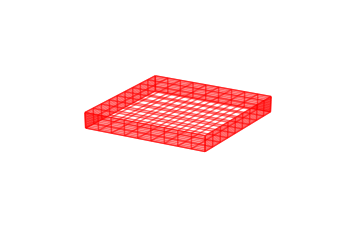

In [ ]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# import numpy as np
# from itertools import product, combinations


# fig = plt.figure()
# ax = fig.gca(projection='3d')


# # draw cube
# r = [-1, 0]
# for s, e in combinations(np.array(list(product(r, r, r))), 2):
#     if np.sum(np.abs(s-e)) == r[1]-r[0]:
#         ax.plot3D(*zip(s, e), color="b")
# r = [1, 1]
# for s, e in combinations(np.array(list(product(r, r, r))), 2):
#     if np.sum(np.abs(s-e)) == r[1]-r[0]:
#         ax.plot3D(*zip(s, e), color="b")
# # make the panes transparent
# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# # make the grid lines transparent
# ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
# ax.set_axis_off()
# plt.show()





# def plot_cuboid(center, size):
#     """
#        Create a data array for cuboid plotting.


#        ============= ================================================
#        Argument      Description
#        ============= ================================================
#        center        center of the cuboid, triple
#        size          size of the cuboid, triple, (x_length,y_width,z_height)
#        :type size: tuple, numpy.array, list
#        :param size: size of the cuboid, triple, (x_length,y_width,z_height)
#        :type center: tuple, numpy.array, list
#        :param center: center of the cuboid, triple, (x,y,z)
#    """
#     # suppose axis direction: x: to left; y: to inside; z: to upper
#     # get the (left, outside, bottom) point
#     import numpy as np
#     ox, oy, oz = center
#     l, w, h = size

#     x = np.linspace(ox-l/2,ox+l/2,num=10)
#     y = np.linspace(oy-w/2,oy+w/2,num=10)
#     z = np.linspace(oz-h/2,oz+h/2,num=10)
#     x1, z1 = np.meshgrid(x, z)
#     y11 = np.ones_like(x1)*(oy-w/2)
#     y12 = np.ones_like(x1)*(oy+w/2)
#     x2, y2 = np.meshgrid(x, y)
#     z21 = np.ones_like(x2)*(oz-h/2)
#     z22 = np.ones_like(x2)*(oz+h/2)
#     y3, z3 = np.meshgrid(y, z)
#     x31 = np.ones_like(y3)*(ox-l/2)
#     x32 = np.ones_like(y3)*(ox+l/2)

#     from mpl_toolkits.mplot3d import Axes3D
#     import matplotlib.pyplot as plt
#     fig = plt.figure()
#     ax = fig.gca(projection='3d')
#     # outside surface
#     ax.plot_wireframe(x1, y11, z1, color='r', rstride=1, cstride=1, alpha=0.6)
#     # inside surface
#     ax.plot_wireframe(x1, y12, z1, color='r', rstride=1, cstride=1, alpha=0.6)
#     # bottom surface
#     ax.plot_wireframe(x2, y2, z21, color='r', rstride=1, cstride=1, alpha=0.6)
#     # upper surface
#     ax.plot_wireframe(x2, y2, z22, color='r', rstride=1, cstride=1, alpha=0.6)
#     # left surface
#     ax.plot_wireframe(x31, y3, z3, color='r', rstride=1, cstride=1, alpha=0.6)
#     # right surface
#     ax.plot_wireframe(x32, y3, z3, color='r', rstride=1, cstride=1, alpha=0.6)
#     ax.set_xlabel('X')
#     ax.set_xlim(-100, 100)
#     ax.set_ylabel('Y')
#     ax.set_ylim(-100, 100)
#     ax.set_zlabel('Z')
#     ax.set_zlim(-100, 100)
#     # make the panes transparent
#     ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#     ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#     ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#     # make the grid lines transparent
#     ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#     ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#     ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
#     ax.set_axis_off()
#     plt.show()



# def test():
#     center = [0, 0, 0]
#     length = 50 * 3
#     width = 50 * 3
#     height = 3 * 10
#     plot_cuboid(center, (length, width, height))
# test()

##**Dimensionality reduction - PCA**

The training dataset will consist of 100 samples of a high-fidelity numerical simulation each with 50 evenly sampled snapshots (in time). Each simulation represents velocity (in x and y directions) and pressure for the turbulent flow model over a region of grid size 256x256. These values can be used to generate a vorticity field for the model. Thus, there is a total number of 256 * 256 = 65,536 variables per time step and a total of 50 * 100 = 5,000 samples. Dimensionality reduction of this high dimensional space is then performed using Principal Component Analysis (PCA) in order to work with a relatively low dimension space

###Load Data

In [ ]:
# Load vortex data as traing data.
X_train3d = np.load('drive/MyDrive/MSC_IRP/data/calc_vortex_100.npy')

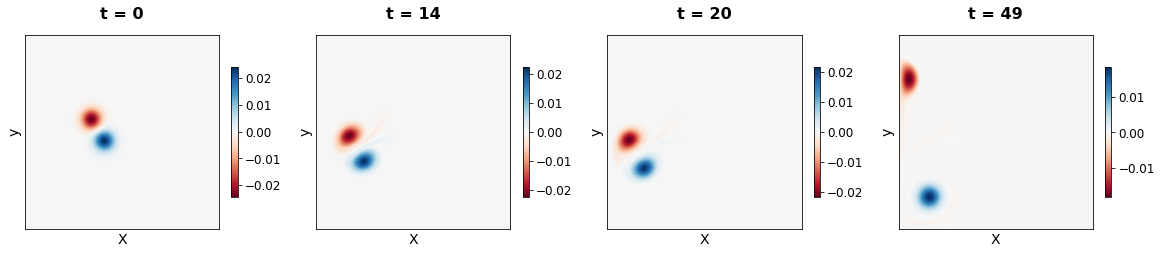

In [ ]:
times = [0, 14, 20, 49]
plot_vortex(X_train3d[58], times)

In [ ]:
nx = len(X_train3d[0][0])
timestep = len(X_train3d[0])
X_train3d.shape

(100, 50, 256, 256)

###Build PCA Model

This PCA model is built using the 292 components that gave > 99.9% variance in the reduction.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

normalize = False # flag to normalize training data before PCA or not.
X_train1d = X_train3d.reshape((-1, nx*nx))
print(X_train1d.shape)

# Normalization
if(normalize):
  X_train1d = StandardScaler().fit_transform(X_train1d)

# Initiate PCA
pca = PCA(X_train1d.shape[0])
X_train_pca = pca.fit_transform(X_train1d)

(5000, 65536)


KeyboardInterrupt: ignored

In [ ]:
X_recovered_1d = pca.inverse_transform(X_train_pca)
np.allclose(X_recovered_1d, X_train1d)

True

In [ ]:
p = 0.999
cumsum_eig = np.cumsum(pca.explained_variance_ratio_)
n_components_eig = np.argmax(cumsum_eig >= p) + 1 # returns the indices of the maximum values along an axis.
n_components_eig

292

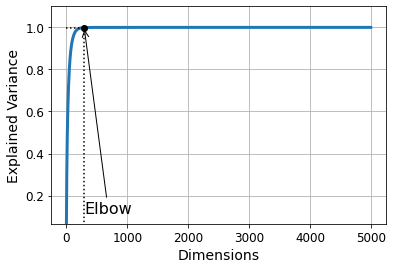

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(cumsum_eig, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.ylim([cumsum_eig[0],1.1])
plt.plot([n_components_eig, n_components_eig], [0, p], "k:")
plt.plot([0, n_components_eig], [p, p], "k:")
plt.plot(n_components_eig, p, "ko")
plt.annotate("Elbow", xy=(n_components_eig, p), xytext=(n_components_eig, cumsum_eig[0]+0.05),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

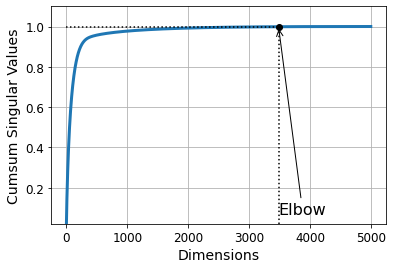

In [ ]:
p = 0.999
cumsum_sv = np.cumsum(pca.singular_values_/sum(pca.singular_values_))
n_components_sv = np.argmax(cumsum_sv >= p) + 1

d = n_components_sv
plt.figure(figsize=(6,4))
plt.plot(cumsum_sv, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Cumsum Singular Values")
plt.ylim([cumsum_sv[0],1.1])
plt.plot([d, d], [0, p], "k:")
plt.plot([0, d], [p, p], "k:")
plt.plot(d, p, "ko")
plt.annotate("Elbow", xy=(d, p), xytext=(d, cumsum_sv[0]+0.05),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()
print(d)

In [ ]:
pca_rom = PCA(n_components=n_components_eig)
X_train_pca = pca_rom.fit_transform(X_train1d)
X_reconstruct = pca_rom.inverse_transform(X_train_pca)
print(X_train_pca.shape)
np.allclose(X_reconstruct, X_train1d)

(5000, 292)


False

In [ ]:
# Comparing actual data and pca reduced data
actual_data = X_train1d.reshape((-1, timestep, nx, nx))[89]
recon_data = X_reconstruct.reshape((-1, timestep, nx, nx))[89]

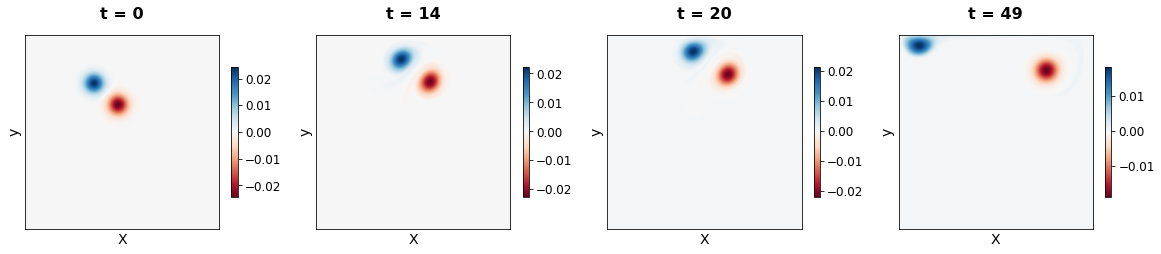

In [ ]:
plot_vortex(actual_data, times)

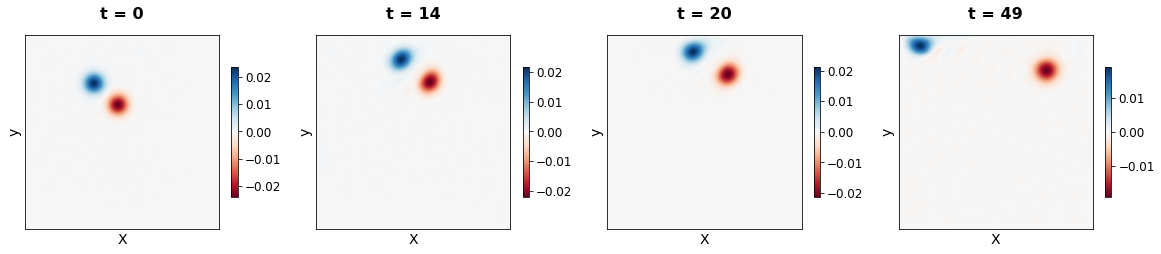

In [ ]:
plot_vortex(recon_data, times)

###Calculate Error

In [ ]:
max_abs_err, mean_abs_err = calculate_error(actual_data, recon_data)
print("Max. abs. error: {}". format(max_abs_err))
print("Mean abs. error: {}".format(mean_abs_err))

Max. abs. error: 0.0026068006677143927
Mean abs. error: 5.0103895884519914e-05


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


###Save PCA model

In [ ]:
import joblib
pca_file_dir = "drive/MyDrive/MSC_IRP/PredGAN/pca_rom_292.pkl"
with open(pca_file_dir, 'wb') as save_file:  
  joblib.dump(pca_rom, save_file)
#np.save('drive/MyDrive/MSC_IRP/data/pca_calc_vortex_100.npy', X_train_pca)

#Training Prediction GAN

Following reduction in dimension, we can now proceed to train a GAN for prediction.

In [6]:
normalize = False # flag to normalize training data before PCA or not.
mem_load = False
num_of_coeff = 292
ntimes = 21 # Consecutive times for the GAN
step = 1 # step between times
version_num = 1

lr = 1e-4
num_examples_to_generate = 5

BATCH_SIZE = 256
latent_space = 100

# Seed and intitialization
seed = tf.random.normal([num_examples_to_generate, latent_space])

###Load Data

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

SAVE_DIR = 'drive/MyDrive/MSC_IRP/PredGAN/'

# Load vortex data as traing data.
X_train3d = np.load('drive/MyDrive/MSC_IRP/data/calc_vortex_100.npy')
nx = len(X_train3d[0][0])
timestep = len(X_train3d[0])

print (nx)
print(timestep)

256
50


In [8]:
if (mem_load):
  X_train1d_pca = np.load('drive/MyDrive/MSC_IRP/data/pca_calc_vortex_100.npy')
  pca = joblib.load('drive/MyDrive/MSC_IRP/PredGAN/pca_rom_292.pkl')
else: 
  X_train1d = X_train3d.reshape((-1, nx*nx))
  # Normalization
  if (normalize):
    X_train1d = StandardScaler().fit_transform(X_train1d)
  # 
  pca = PCA(num_of_coeff)
  X_train1d_pca = pca.fit_transform(X_train1d)
  print(X_train1d_pca.shape)

(5000, 292)


In [9]:
# test 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train1d_pca_scaled = scaler.fit_transform(X_train1d_pca)
np.allclose(X_train1d_pca, scaler.inverse_transform((X_train1d_pca_scaled)))


True

###Visualize Data

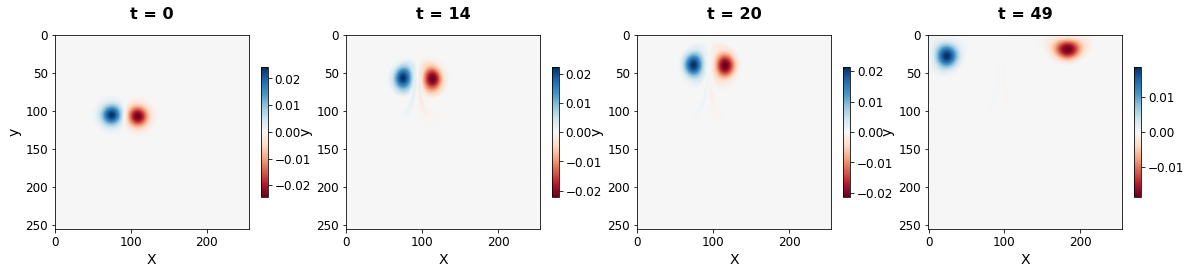

In [8]:
times = [0, 14, 20, 49]
plot_vortex(X_train3d[69], times)

(100, 50, 256, 256)


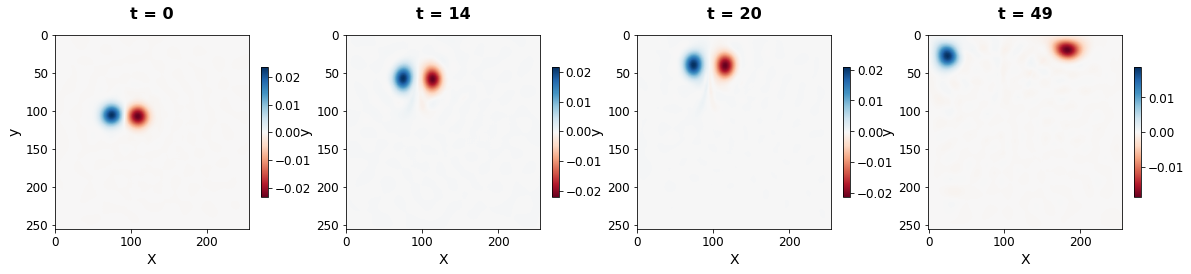

In [9]:
# Inverse PCA plots
X_recovered = pca.inverse_transform(X_train1d_pca).reshape(-1,timestep, nx, nx)
print(X_recovered.shape)
plot_vortex(X_recovered[69], times)

(100, 50, 256, 256)


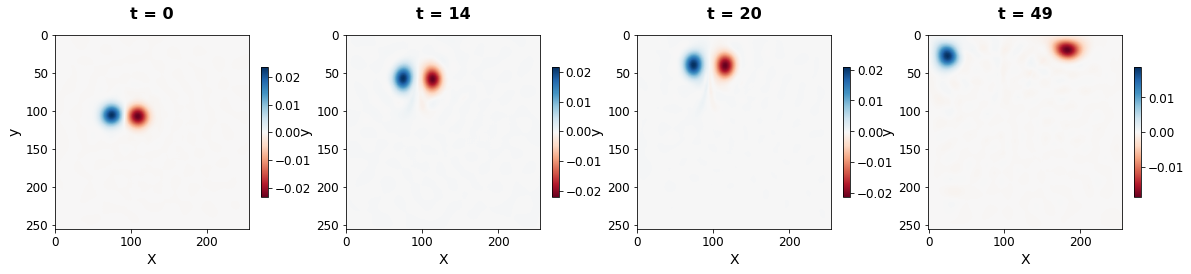

In [11]:
# Inverse scaling and inverse PCA plots
X_recovered = invert_data(X_train1d_pca_scaled).reshape(-1,timestep, nx, nx)
print(X_recovered.shape)
plot_vortex(X_recovered[69], times)

### Time series Concatenation

In [18]:
sample_size = X_train3d.shape[0] #100 separate samples
window_start = [(sample*timestep)for sample in range(sample_size)]
window_end = [(sample*timestep) - (ntimes*step) for sample in range(1, sample_size + 1)]


X_train_concat = concat_timesteps(X_train1d_pca_scaled, ntimes, step, window_start, window_end)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], num_of_coeff*ntimes)
print(X_train_concat.shape)
print(X_train_concat_flatten.shape)

(3000, 21, 292)
(3000, 6132)


###Train GAN

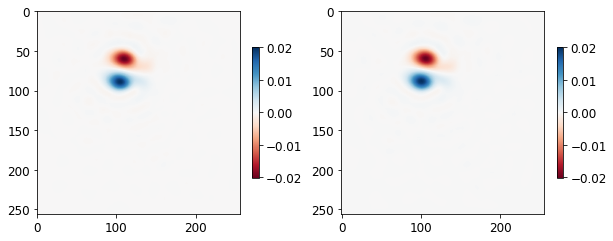

In [13]:
# Reverse transform concatenated series to check correctness
fig, ax = plt.subplots(1, 2, figsize=[10,10])
X_ = invert_data(X_train_concat[69, :, :])
im = ax[0].imshow(X_[0,:].reshape(nx, nx), cmap='RdBu')
im = ax[1].imshow(X_[1, :].reshape(nx, nx), cmap='RdBu')
fig.colorbar(im, ax=ax.flatten()[0], shrink=0.24, pad=0.05, panchor=(0.0, 0.0))
fig.colorbar(im, ax=ax.flatten()[1], shrink=0.24, pad=0.05, panchor=(0.0, 0.0))
plt.show()

In [ ]:
X_.shape

(21, 65536)

Dataset Creation

In [14]:
BATCH_SIZE = 256
latent_space = 100

# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], ntimes, num_of_coeff, 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_concat)).batch(BATCH_SIZE)

Generator Model

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(5*12*512, use_bias=False, input_shape=(latent_space,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Reshape((5, 12, 512)))

    model.add(keras.layers.Conv2DTranspose(256, (3, 7), strides=(1, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU()) 

    model.add(keras.layers.Conv2DTranspose(128, (3, 7), strides=(1, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(64, (3, 7), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(32, (3, 7), strides=(2, 2), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())

    model.add(keras.layers.Conv2DTranspose(1, (3, 7), strides=(2, 3), padding ='valid', output_padding=[0,0], use_bias=False, activation='tanh'))

    return model
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30720)             3072000   
_________________________________________________________________
batch_normalization (BatchNo (None, 30720)             122880    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30720)             0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 12, 512)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 24, 256)        2752512   
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 24, 256)        1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 24, 256)        0

Testing the model generator

(1, 21, 292, 1)
(21, 65536)


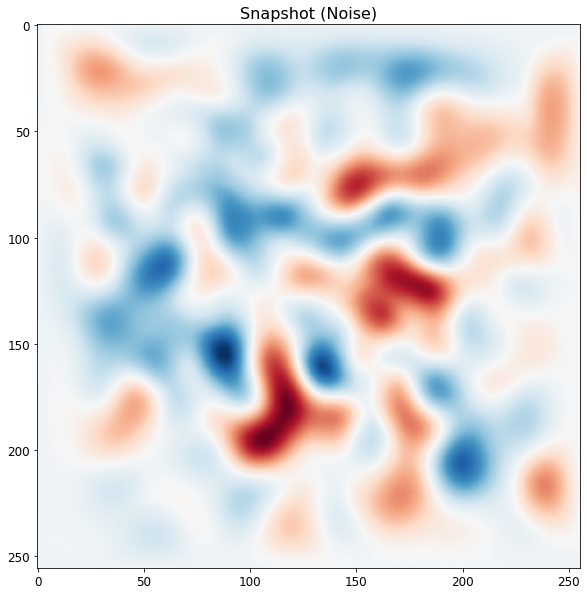

In [16]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

fig, ax = plt.subplots(figsize=[10,10])
inv_generated_image = invert_data(generated_image[0, :, :, 0])
print(inv_generated_image.shape)
ax.imshow(inv_generated_image[0, :].reshape(nx, nx), cmap='RdBu');
ax.set_title('Snapshot (Noise)', fontsize=16);

Discriminator

In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same',
                                     input_shape=[ntimes, num_of_coeff, 1]))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(128, (5, 7), strides=(1, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(64, (5, 7), strides=(1, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv2D(32, (5, 7), strides=(1, 2), padding='same'))
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 146, 64)       640       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 11, 146, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 146, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 73, 128)       286848    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 11, 73, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 73, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 37, 64)       

Test disciriminator model

In [18]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00038315]], shape=(1, 1), dtype=float32)


Generative Model


In [19]:
version_num = 1
gan = keras.models.Sequential ([generator, discriminator])

Cost Function and Optimization

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return fake_loss

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

# Optimizers for generator and optimizer models

generator_optimizer = tf.keras.optimizers.Adam(lr)
discriminator_optimizer = tf.keras.optimizers.Adam(lr)


In [24]:
# logs to document losses

generator_log_dir = SAVE_DIR + 'logs/generator_v' + str(version_num) + '_'+ str(num_of_coeff)
discriminator_log_dir = SAVE_DIR + 'logs/discriminator_v' + str(version_num) + '_'+ str(num_of_coeff)
gen_summary = tf.summary.create_file_writer(generator_log_dir)
disc_summary = tf.summary.create_file_writer(discriminator_log_dir)

print('Version no.: ', version_num)
print('POD coeffiecients: ', num_of_coeff)
print('Batch size: ', BATCH_SIZE)
print('Learning Rate: ', lr)

Version no.:  1
POD coeffiecients:  292
Batch size:  256
Learning Rate:  0.0001


Training step

In [26]:

def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, latent_space])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    generator_mean_loss(gen_loss)
    discriminator_mean_loss(disc_loss)

Training loop

In [33]:
def train(dataset, epochs):
    hist = []
    for epoch in range(epochs+1):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, epochs))   

        for batch in dataset:
            train_step(batch)
            
        with gen_summary.as_default():
            tf.summary.scalar('loss', generator_mean_loss.result(), step=epoch)

        with disc_summary.as_default():
            tf.summary.scalar('loss', discriminator_mean_loss.result(), step=epoch)
        
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        print("discriminator loss: ", "{:.6f}".format(hist[-1][1]), end=' - ')
        print("generator loss: ", "{:.6f}".format(hist[-1][0]), end=' - ')    
        print ('{:.0f}s'.format( time.time()-start))

        pred_time_len = 4
        # Global variables are used below
        if epoch%1000 == 0: 
            # Plot generated data
            X_generated = generator.predict(seed).reshape(-1, num_of_coeff)
            X_generated = invert_data(X_generated)
            print(X_generated.shape)
            X_generated = X_generated.reshape(num_examples_to_generate, ntimes, nx, nx)
            fig, ax = plt.subplots(num_examples_to_generate, pred_time_len, figsize=[20, 25], constrained_layout=True)
            for j in range(num_examples_to_generate):
              for i in range(pred_time_len):
                im = ax.flatten()[i + (pred_time_len*j)].imshow(X_generated[j][i,:,:], cmap='RdBu')
                ax[j,i].set_xticklabels([]), ax[j,i].set_yticklabels([])
              fig.colorbar(im, ax=ax[j,:], location='right', shrink=0.8, pad=0.05)
            plt.show() 
                    
            # Save model
            # gan.save(SAVE_DIR + 'ganmodels/'+str(epoch)+'.h5')    
            gan.save(SAVE_DIR + 'ganmodels/model_v'+ str(version_num) + '_'+ 
                                        str(num_of_coeff)+'_'+str(epoch)+'.h5')  
            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_gen', 'loss_disc'])
            ax.set_yscale('log')
            ax.grid()
            plt.show()
            
    return hist


In [ ]:
import time
hist = train(train_dataset, epochs=50000)

#Prediction with GAN

### Sample generation

(105, 65536)


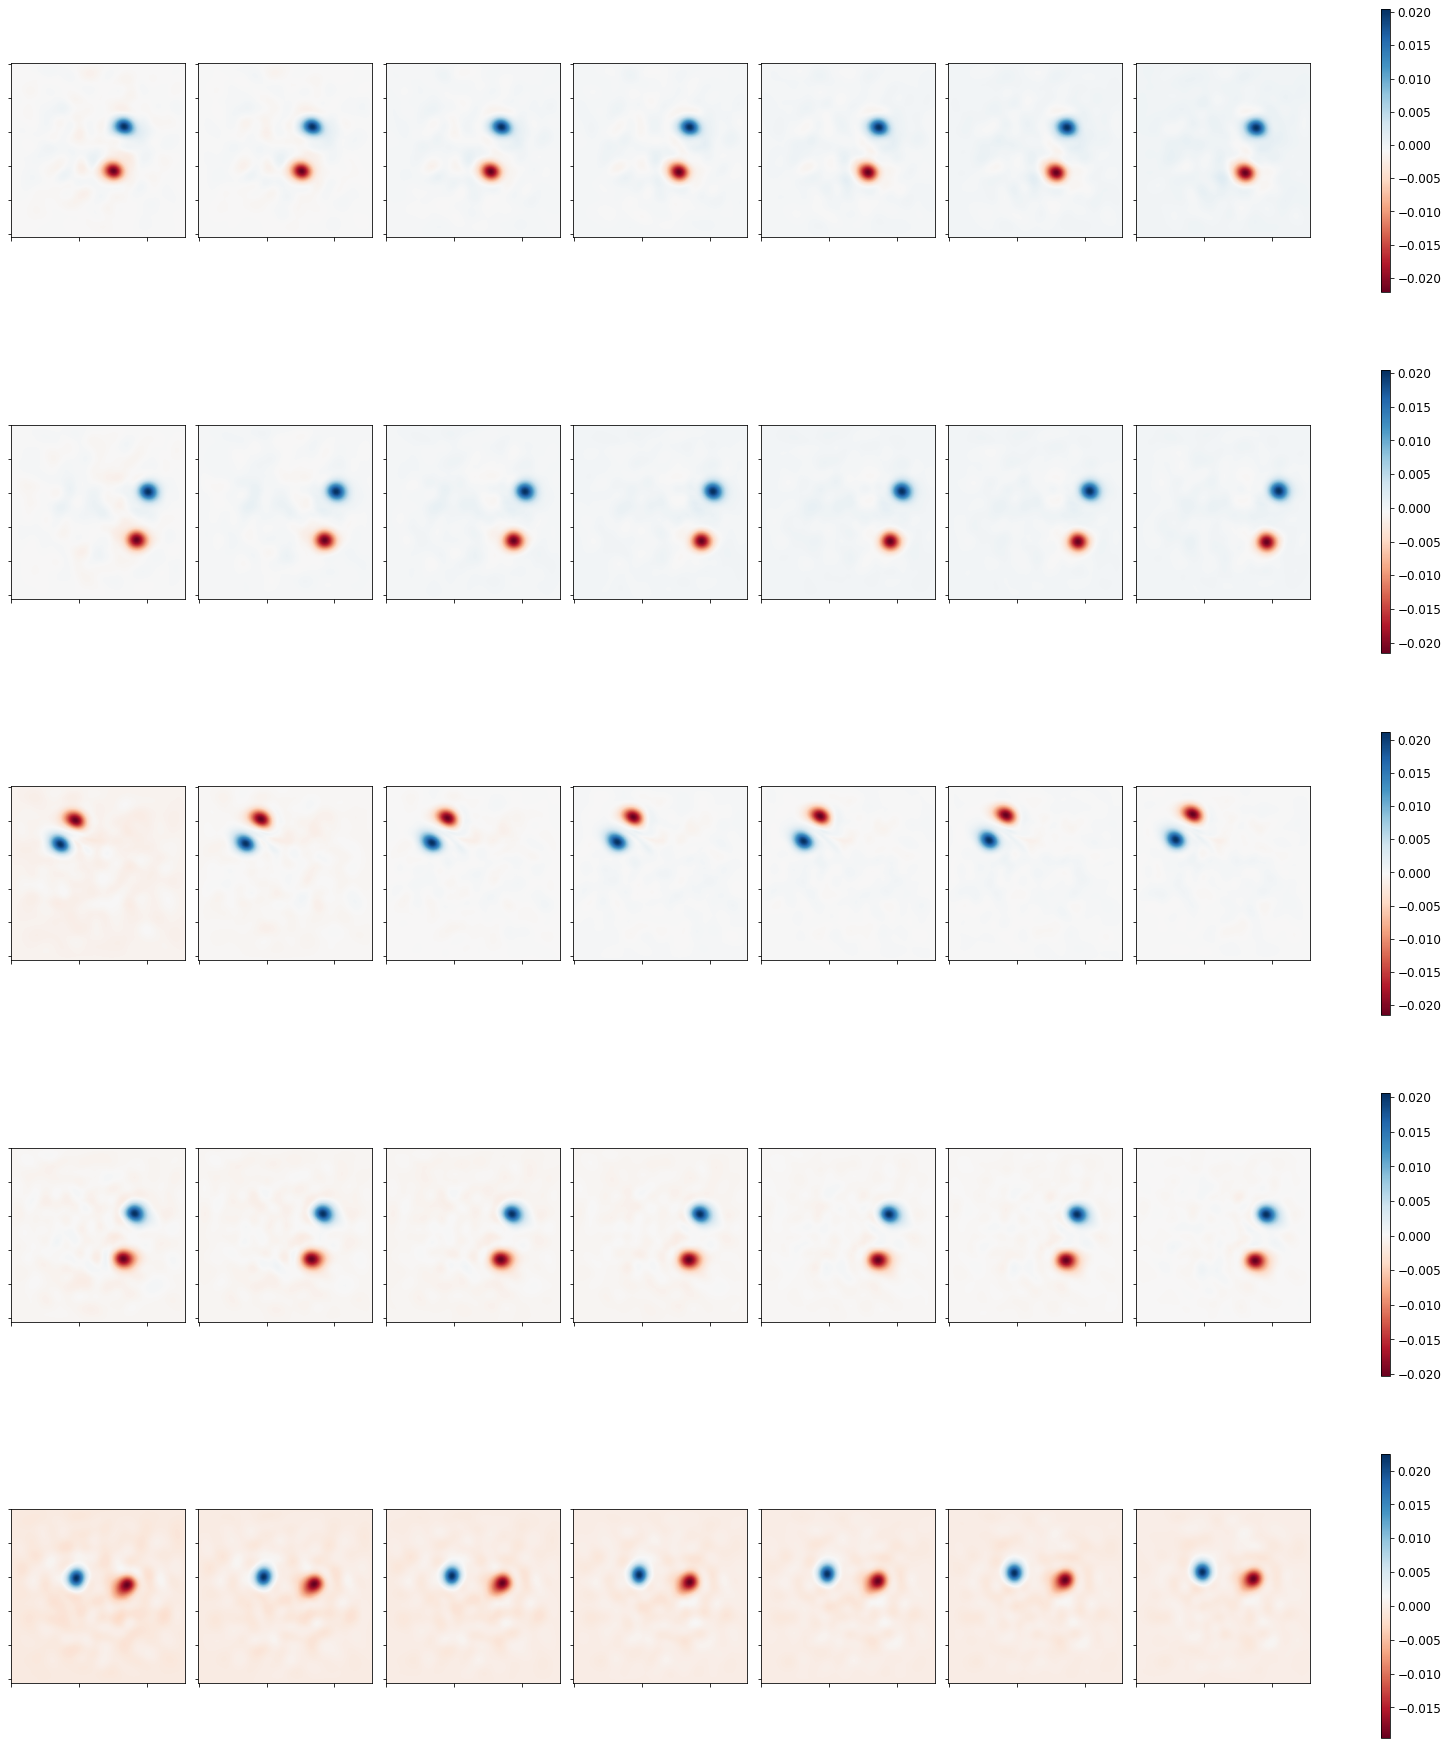

In [11]:
from tensorflow.keras.models import load_model
generator, discriminator = load_model(SAVE_DIR+'ganmodels/model_v1_292_22000.h5').layers

np.random.seed(0)
tf.random.set_seed(0)

npredict = 5
latent_size = 100
pred_time_len = 7
noise = tf.random.normal(shape=[npredict, latent_size])
X_generated = generator.predict(noise).reshape(-1, num_of_coeff)
X_generated = invert_data(X_generated)
print(X_generated.shape)
X_generated = X_generated.reshape(num_examples_to_generate, ntimes, nx, nx)
fig, ax = plt.subplots(num_examples_to_generate, pred_time_len, figsize=[20, 25], constrained_layout=True)
for j in range(num_examples_to_generate):
  for i in range(pred_time_len):
    im = ax.flatten()[i + (pred_time_len*j)].imshow(X_generated[j][i,:,:], cmap='RdBu')
    ax[j,i].set_xticklabels([]), ax[j,i].set_yticklabels([])
  fig.colorbar(im, ax=ax[j,:], location='right', shrink=0.8, pad=0.05)
plt.show() 

### Predict a point in time

In [84]:
weight = tf.constant(pca.singular_values_, dtype=tf.float32)

In [19]:
codings_size = num_of_coeff
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-2)

def mse_loss(inp, outp, loss_weight):
    inp = tf.reshape(inp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    outp = tf.reshape(outp, [-1, codings_size])*tf.math.sqrt(loss_weight)
    return mse(inp, outp)

In [25]:

def opt_step(latent_values, real_coding, loss_weight):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)  #results from generator
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:], loss_weight)   
        #codings_size is size of each output, ntimes is number of time levels. 
        #If training for 9 time levels, it finds the loss between the first 8 outputs from the generator and 8 real outputs

    gradient = tape.gradient(loss, latent_values)   #gradient of the loss ws to the input
    optimizer.apply_gradients(zip([gradient], [latent_values]))   #applies gradients to the input
    
    return loss

In [34]:
def optimize_coding(real_coding, loss_weight):
    latent_values = tf.random.normal([len(real_coding), latent_size])  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(50000):
        loss.append(opt_step(latent_values, real_coding, loss_weight).numpy())
        
    plt.plot(loss)
    plt.grid()
    plt.show
        
    return latent_values  #returns the optimized input that generates the desired output

(3000, 6132)
(1, 6132)
(1, 5840)
Loss:  0.009083381
<tf.Variable 'Variable:0' shape=(1, 100) dtype=float32, numpy=
array([[-5.4587870e+00,  1.3692488e+01,  7.9550686e+00,  7.3722720e-01,
        -9.7818174e+00,  2.2384520e+00,  4.2501359e+00,  8.1581059e+00,
         3.6962519e+00,  8.6717540e-01, -3.8409843e+00,  1.1421494e+00,
         1.1081189e-02,  3.7425523e+00,  7.8404679e+00,  5.1494522e+00,
         2.0482484e-01, -4.2586264e-01,  6.5952582e+00, -2.9225824e+00,
        -5.3495865e+00, -7.1765809e+00,  5.5217320e-01, -6.0035706e+00,
         1.9695899e+00, -6.4305973e-01,  5.2374196e+00, -6.2299573e-01,
         3.0347993e+00,  7.3763247e+00, -4.8185644e+00, -1.8314954e+00,
         1.3592792e+01,  1.4111195e+01,  2.2606106e+00,  5.4067512e+00,
         2.5141797e+00, -7.5342340e+00, -6.3658094e+00, -5.3810430e+00,
         7.2301750e+00, -4.7298017e+00, -9.7724924e+00,  1.1562261e+01,
        -1.7285912e-01,  8.9262333e+00, -1.0651048e+00, -5.9792280e+00,
         1.6814662e+0

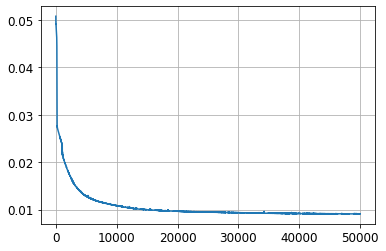

In [35]:
n = 2000 # arbitrary sample
print(X_train_concat_flatten.shape)
real_coding = X_train_concat_flatten[n].reshape(1,-1)
print(real_coding.shape)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
print(real_coding.shape)
real_coding = tf.constant(real_coding)  
real_coding = tf.cast(real_coding, dtype=tf.float32)
latent_values = optimize_coding(real_coding, weight)
print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding, weight).numpy())
print(latent_values)

In [82]:
X_gen = generator.predict(np.asarray(latent_values)).reshape(ntimes,codings_size)
X_gen = invert_data(X_gen)
print(X_gen.shape)
X_gen = X_gen.reshape(ntimes, nx*nx)

(21, 65536)


In [37]:
X_real = X_train_concat_flatten[n].reshape(ntimes,codings_size)
X_real = invert_data(X_real)
print(X_real.shape)
X_real = X_real.reshape(ntimes, nx*nx)

(21, 65536)


**Generated Data**

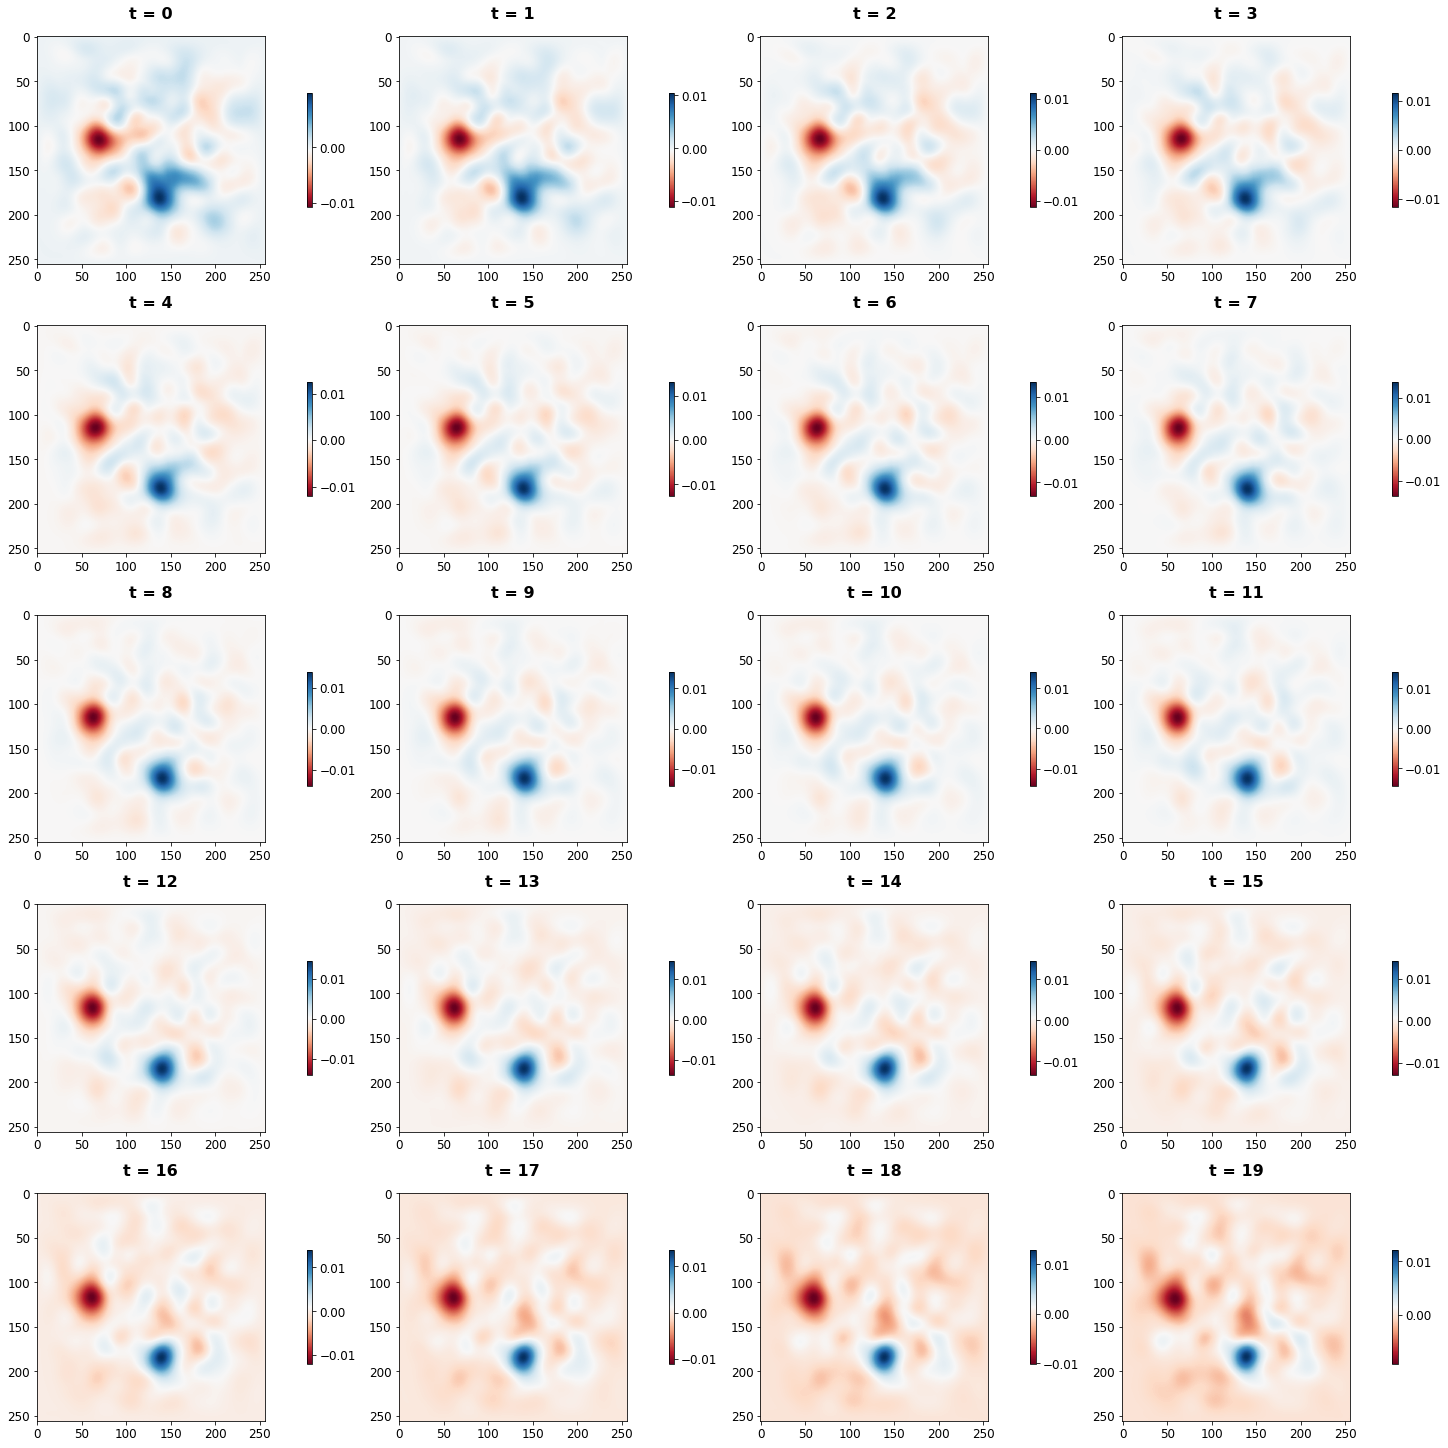

In [83]:
times = [i for i in range(ntimes-1)]
plot_vortex(X_gen.reshape(ntimes, nx, nx), times, 4, 5)

**Real Data**

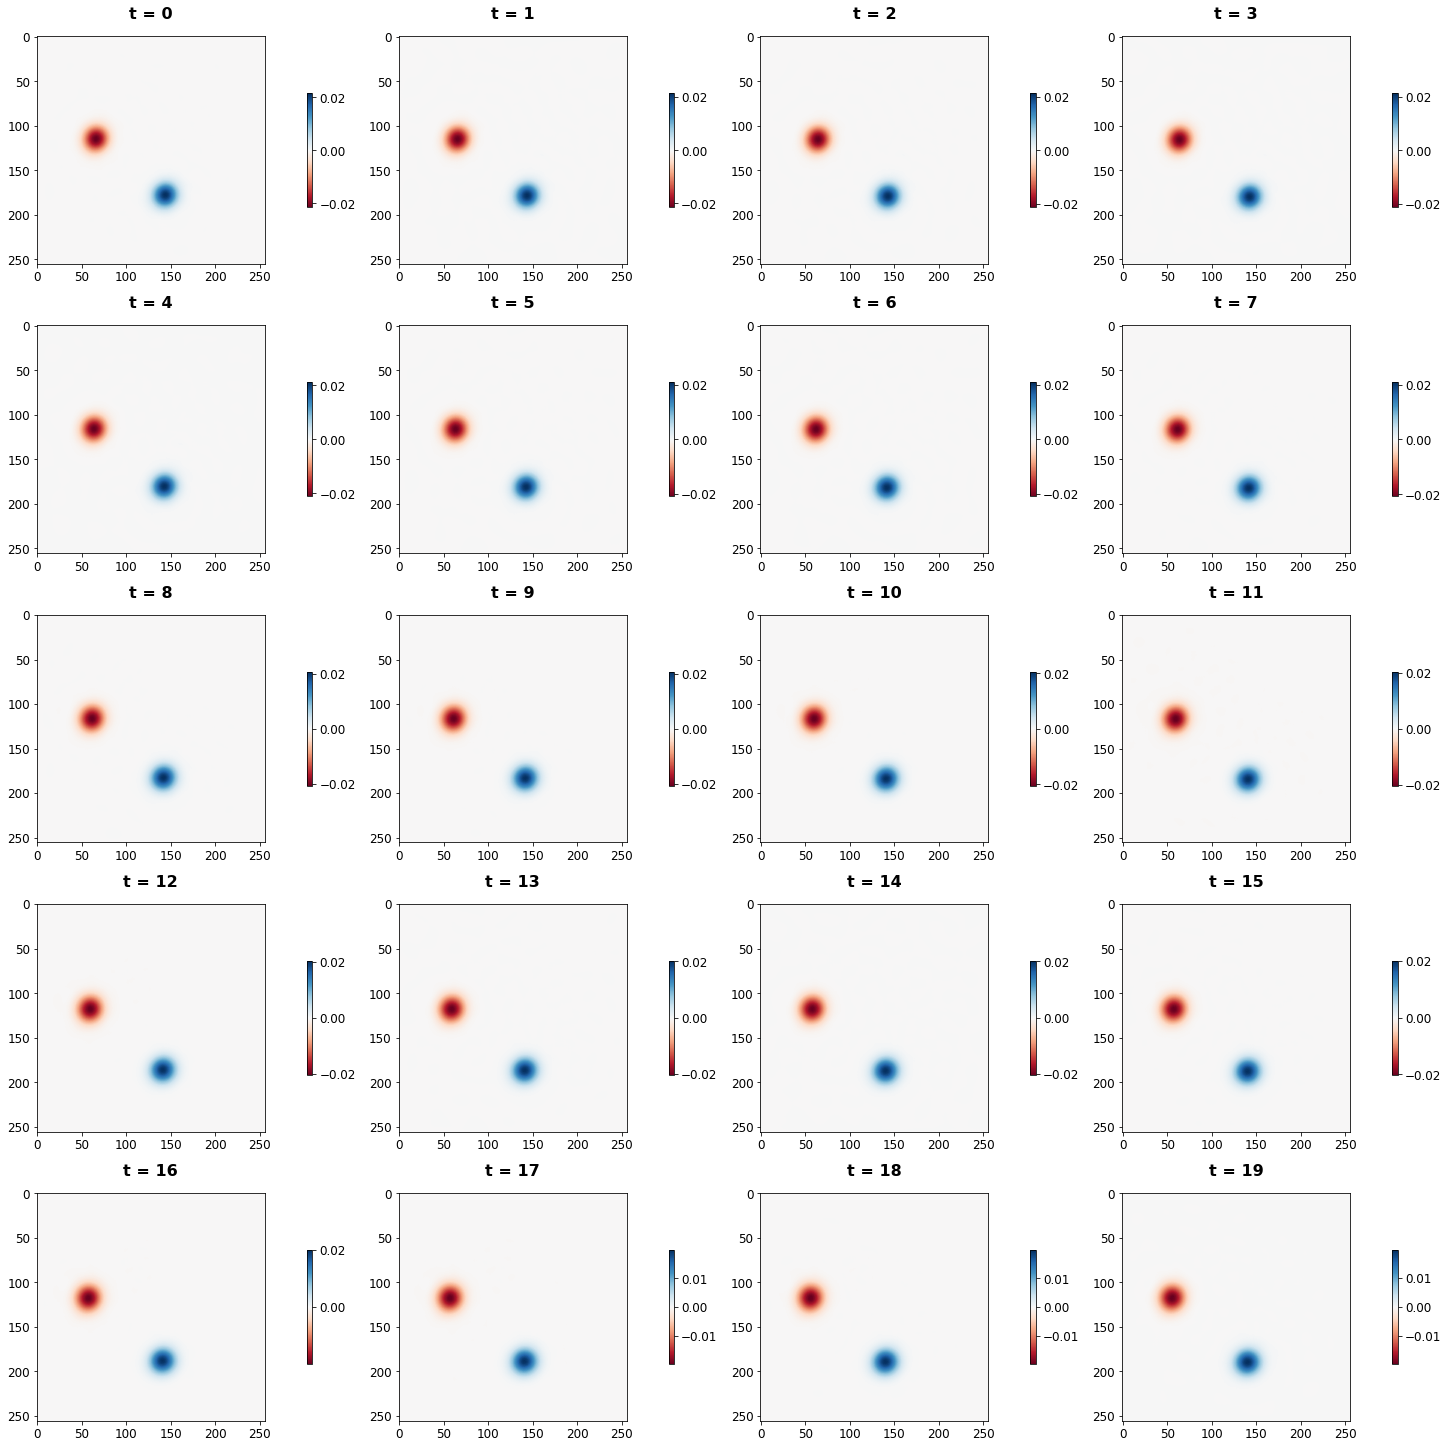

In [75]:
plot_vortex(X_real.reshape(ntimes, nx, nx), times, 4, 5)

**Comparing Predicted and Real Data for 20th timestep**

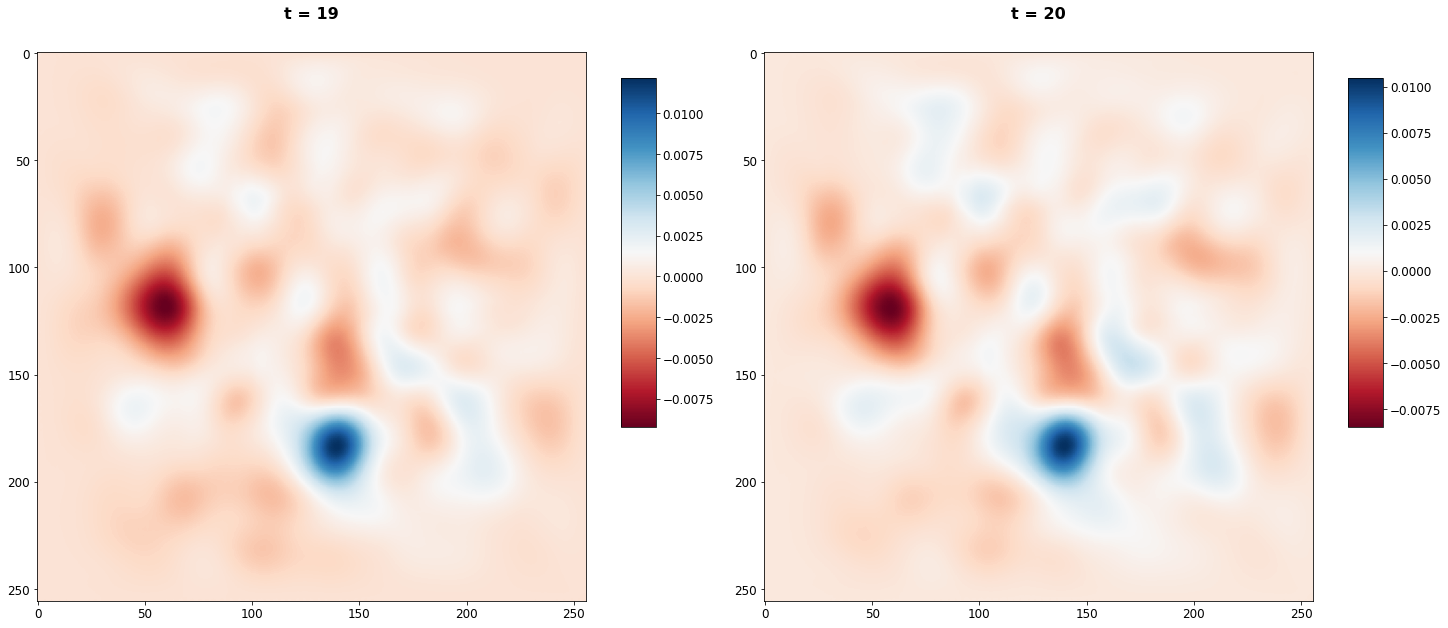

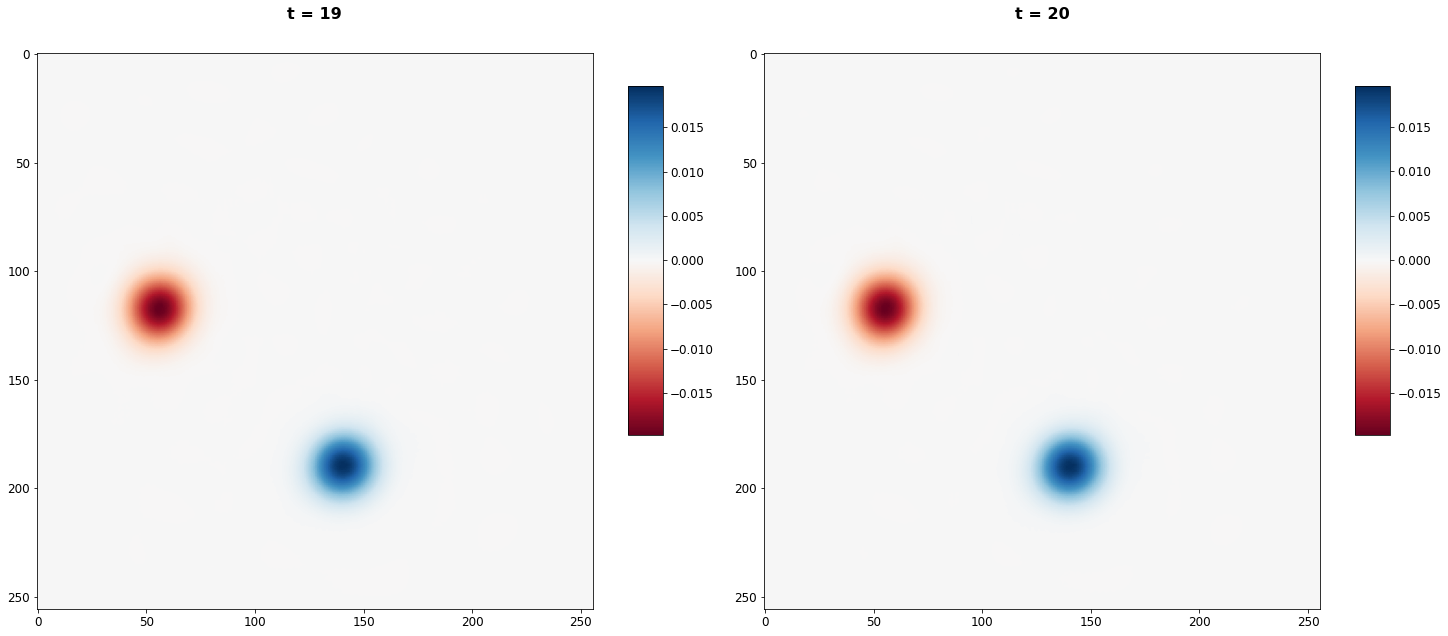

In [78]:
plot_vortex(X_gen.reshape(ntimes, nx, nx), [ntimes-2, ntimes-1], 2)
plot_vortex(X_real.reshape(ntimes, nx, nx), [ntimes-2, ntimes-1],2)

In [ ]:
X_diff